In [1]:
%matplotlib inline
#Plot
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True)

#Data Packages
import math
import pandas as pd
import numpy as np

#Util
from collections import Counter
import operator
import copy
from PIL import Image

#Natural Language Processing Packages
import re
import nltk
from nltk.stem import *
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from whoosh.analysis import *
from whoosh.analysis import Filter


## Machine Learning
import sklearn
import sklearn.metrics as metrics

# HTML
import html


### NOTE: There are some TensorFlow based libraries used in the latter part of the notebook.

### Part 0: Read txt into pandasDF or List

In [2]:
# read classified tweets as a pandasDF, with 1st row as column name
classified_df= pd.read_csv(('classified_tweets.txt'),sep=",",header = 0,encoding='utf-8')

# read unclassifed tweets as list
with open("unclassified_tweets.txt","r",encoding="UTF-8") as f:
    temp = f.readlines()
    unclassified_list = [x.strip() for x in temp]

In [3]:
# show length of classified tweets
classified_df.shape[0]

200000

In [4]:
# show length of unclassified tweets
len(unclassified_list)

6159

In [5]:
# visualize top 3 rows in classified_df
classified_df.head(3)

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


In [6]:
# visualize top 5 rows in unclassified_list
unclassified_list[:5]

['\ufeffliving the dream. #cameraman #camera #cameraception #camera #cameras #marriott #feet #tommulcair… instagram.com/p/8up9qepkxw/',
 '',
 "justin #trudeau's reasons for thanksgiving. today's montreal@themoment blog at bit.ly/1jqkfwr\xa0 #elxn42 poll #quebec #montreal",
 '',
 '@themadape   butt…..butt…..we’re allergic to latex! makes us sneeze this in #nbpoli #cdnpoli pic.twitter.com/ta0llla4jk']

### Part 1: Data Cleaning
#### Part 1.1: Defining Utility functions for cleaning process
In this section, tweets are cleaned by first removing html tags and attributes and URLs. Then HTML character codes are unescaped into ASCII equivalent. Text are lowercased, tokenized and then lemmatized using NLTK and Whoosh library. Frequent stopwords with low informative level are removed. After preprocessing, the cleaned tweets with empty content are dropped.

Additionally, for unclassified tweets, hashtages content are extracted and added into another column in the unclassified tweet pandasDF.

In [7]:
class CustomFilter(Filter):
    '''
    Utility class for Whoosh to build customize filter with tools from 
    '''
    is_morph = True
    def __init__(self, filterFunc, *args, **kwargs):
        self.customFilter = filterFunc
        self.args = args
        self.kwargs = kwargs
    def __eq__(self):
        return (other
                and self.__class__ is other.__class__)
    def __call__(self, tokens):
        for t in tokens:
            if t.mode == 'query': # if called by query parser
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t
            else: # == 'index' if called by indexer
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t

def tweet_parsing(uncleaned, hashtag=False):
    '''
    Clean the text and extract hashtag content
    input: 
        uncleaned: array-like
    output:
        if hashtag=false:
            cleaned : array-like
        if hashtag=true:
            cleaned : list
            hashtag_list: list[list]
    '''
    
    # make a deepcopy
    temp = copy.deepcopy(uncleaned)
    
    # remove url in shape of (...).(...)/(...)
    temp = [re.sub(r'(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-z]{2,6}([-a-zA-Z0-9@:%_\+.~#?&//=]*)','',x)\
            for x in temp]
    
    # remove html tag 
    temp = [html.unescape(x) for x in temp]
    
    # remove numbers
    temp = [re.sub(r'[0-9]*','',x) for x in temp]
    
    # remove hashtag, including #1 or intra-word like A#B
    temp = [re.sub(r'#\w+','',x) for x in temp]
    
    # remove non-word chars
    temp = [re.sub(r'[^\s\w]+','',x) for x in temp]
    
    # customized filter using whoosh. Performs:
    # lower caseing, intra-word filtering, stopword removing, lemmatizing verbs.
    myFilter = RegexTokenizer() | LowercaseFilter() |\
               IntraWordFilter() | StopFilter()  | CustomFilter(WordNetLemmatizer().lemmatize,'v')
    for idx, value in enumerate(temp):
        temp[idx] = ' '.join([x.text for x in myFilter(value)])
    
    # if switch turned on, return hashtag for each tweet from input list
    if hashtag:
        hashtag_list = []
        for _ in uncleaned:
            hash_pattern = re.compile(r'(?<=\s#)\w+')
            hash_content = hash_pattern.findall(_)
            hashtag_list.append(hash_content)       
        return temp, hashtag_list
    
    return temp

#### 1.2 Apply cleaning function to cleaned_tweet pandasDF

In [8]:
# Add a column containing Cleaned_text using tweet_parsing funciton above
classified_df['cleaned_text'] = tweet_parsing(classified_df['text'])

In [9]:
# vidualize classified_df with cleaned_text3
classified_df

,class,id,date,query,user,text,cleaned_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww thats bummer shoulda get david...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset he cant update his facebook texting migh...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive many time ball manage save rest ...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feel itchy like its fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no its behave all im mad why b...
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,kwesidei whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug,need hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...,loltrish hey long time no see yes rain bite on...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it,tatiana nope they didnt
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?,twittera que me muera


#### 1.3 Apply cleaning function to unclassified list

In [10]:
# Get cleaned unclassified text, and hashtag_list from unclassified tweet
# by applying cleaning function
cleaned_unclassified_list, unclassified_hashtag_list = \
                        tweet_parsing(unclassified_list, hashtag=True)
    
# Prepare a ictionary of lists for pandasDF
temp_unclassified_dict = {'hashtag':unclassified_hashtag_list,'unclassified':unclassified_list, 'cleaned_unclassified':cleaned_unclassified_list}

In [11]:
# Create a pandas datafame containing original unclassified_twt, cleaned_twt, and hashtags.
unclassified_pd = pd.DataFrame(temp_unclassified_dict)

In [12]:
# visualize the unclassified_pd
unclassified_pd

,cleaned_unclassified,hashtag,unclassified
0,live dream,"[cameraman, camera, cameraception, camera, cam...",﻿living the dream. #cameraman #camera #camerac...
1,,[],
2,justin reason thanksgiving todays montrealthem...,"[trudeau, elxn42, quebec, montreal]",justin #trudeau's reasons for thanksgiving. to...
3,,[],
4,themadape buttre allergic latex make sneeze,"[nbpoli, cdnpoli]",@themadape butt…..butt…..we’re allergic to l...
5,,[],
6,massive explosions peace march kill turkey con...,"[turkey, cdnpoli]",2 massive explosions at peace march in #turkey...
7,,[],
8,suggest theres bad blood between him,"[trudeau, ready4change, ndp]",#mulcair suggests there’s bad blood between hi...
9,,[],


In [13]:
# Remove the empty tweets, get the length again
unclassified_pd =  unclassified_pd[unclassified_pd['cleaned_unclassified'] != ""]
unclassified_pd = unclassified_pd.reset_index(drop=True)
unclassified_text = unclassified_pd['cleaned_unclassified']
unclassified_pd.shape

(2663, 3)

In [14]:
unclassified_pd.head()

,cleaned_unclassified,hashtag,unclassified
0,live dream,"[cameraman, camera, cameraception, camera, cam...",﻿living the dream. #cameraman #camera #camerac...
1,justin reason thanksgiving todays montrealthem...,"[trudeau, elxn42, quebec, montreal]",justin #trudeau's reasons for thanksgiving. to...
2,themadape buttre allergic latex make sneeze,"[nbpoli, cdnpoli]",@themadape butt…..butt…..we’re allergic to l...
3,massive explosions peace march kill turkey con...,"[turkey, cdnpoli]",2 massive explosions at peace march in #turkey...
4,suggest theres bad blood between him,"[trudeau, ready4change, ndp]",#mulcair suggests there’s bad blood between hi...


### 2. Exploratory analysis
#### 2.0 Explore hashtag distributions
In order to determine the political party of a given tweet, the hashtags extracted in the last section are analyzed. The number of appearance of each hashtag are counted with an Counter function. Then the counted hashtags are sorted in descending frequency order.

Political related hashtags are searched through google to identify the party affilication. Due to the large number of the distinct hashtages, only the hashtag with appearance >=3 are analyzed. The tweets are labeled based on the hashtags. If none of the hashtags are party related, it will be labeled as NA.

In [15]:
# util function to merge all list into one list
def merge(original)->list:
    '''
    Input: 
      origional: list[list[],] , hashtag list of each tweet for a list of tweets
    Output:
      hashtag_list: list, list of unique hashtags
    '''
    hashtag_list = []
    for each in original:
        hashtag_list.extend(each)
    return hashtag_list

In [16]:
hashtag_list = merge(unclassified_hashtag_list)
distinct_hashtags = set(hashtag_list)

In [17]:
# total number of distinct hashtags
print("Count of distinct hashtags: %d"% (len(distinct_hashtags)))

Count of distinct hashtags: 1248


In [18]:
# total number of hashtags with repeat
print("Count of hashtags: %d" % (len(hashtag_list)))

Count of hashtags: 6178


In [19]:
# visualize all distinct hashtags
distinct_hashtags

{'yegcentre',
 'corvette',
 'stategicvoting',
 'senate',
 'thehill',
 'wevotebloc',
 'northvan',
 'plq',
 'canadavote',
 'girlpower',
 'religious',
 'harpernomore',
 'ottawasouth',
 'palestine',
 'cdpoli',
 'amerika',
 'canadians',
 'tallahassee',
 'heroes',
 'cometogether',
 'weirdalyankovic',
 'bairdallegedly',
 'paglia',
 'votejohnbarlow',
 'cfsfcee',
 'refugeecrisis',
 'kashmir',
 'elxn42clickmonkeys',
 'ndp2015',
 'marriot',
 'jobless',
 'quadra',
 'middleclass',
 'inadequate',
 'former',
 'elxb42',
 'pkp',
 'canadian',
 'millenial',
 'realquestion',
 'krystenritter',
 'cameraception',
 'housing',
 'thishour',
 'pittmeadows',
 'parkdale',
 'shuswap',
 'funnynews',
 'neverhadarealjob',
 'coldlake',
 'oilsands',
 'vancouver',
 'veterans',
 'qs',
 'hopeoverfear',
 'carebeareconomics',
 'ccfipa',
 'sameshitdifferenthairstyles',
 'cruzcrew',
 'privacy',
 'yyj',
 'christians',
 'gmo',
 'dartmouthcoleharbour',
 'niqabs',
 'nocredibility',
 'newyorker',
 'abc2015',
 'harpersbrain',
 'nare

In [20]:
# count of occurance of each distinct hashtag
Counter(hashtag_list).most_common()

[('cdnpoli', 934),
 ('elxn42', 778),
 ('ndp', 246),
 ('lpc', 200),
 ('cpc', 160),
 ('harper', 148),
 ('realchange', 138),
 ('liberal', 126),
 ('trudeau', 113),
 ('conservative', 104),
 ('justintrudeau', 87),
 ('mulcair', 81),
 ('primeminister', 74),
 ('canada', 56),
 ('justnotready', 53),
 ('elxn2015', 51),
 ('tcot', 49),
 ('onpoli', 46),
 ('tommulcair', 45),
 ('elexn42', 43),
 ('tpp', 43),
 ('thomasmulcair', 30),
 ('tm4pm', 29),
 ('vote', 29),
 ('tlmep', 29),
 ('polcan', 28),
 ('stopharper', 28),
 ('ready4change', 27),
 ('bcpoli', 27),
 ('polqc', 26),
 ('fed2015', 26),
 ('stevenharper', 26),
 ('teaparty', 24),
 ('election2015', 24),
 ('npd', 21),
 ('canpoli', 20),
 ('liberals', 20),
 ('teamtrudeau', 19),
 ('gpc', 19),
 ('canadavotes', 19),
 ('c51', 19),
 ('ccot', 19),
 ('nlpoli', 16),
 ('niqab', 15),
 ('electionscanada', 15),
 ('heavesteve', 15),
 ('cndpoli', 15),
 ('abpoli', 15),
 ('quebec', 14),
 ('bluejays', 14),
 ('obama', 13),
 ('qcpoli', 13),
 ('nspoli', 12),
 ('topoli', 12),
 (

#### 2.1 Assign party label according to hashtag groups

In [21]:
# define dictionaries for different party's hashtag
liberal_list = ['lpc', 'realchange', 'liberal', 'trudeau', 'justintrudeau', 'justnotready', 'liberals', 'teamtrudeau',
 'trudeaus', 'evanassif2015', 'rednationrising', 'trudeau2015', 'quipetrudeau', 'liberalparty', 'voteliberals',
 'trudeaumania', 'generationtrudeau', 'canadianliberals', 'torstarlpc', 'justintrdeau', 'lpcmagine', 'liberalism',
 'trudeauforpm', 'votetrudeau', 'nolpc', 'liberallogic', 'justintime', 'trudeaulite', 'justinoverhishead', 'isupporttrudeau',
 'liberalsarehypocrites', 'sayno2trudeau', 'realchangenow', 'justintrudeaus', 'nototrudeau']


In [22]:
conservative_list = ['cpc','harper','conservative', 'tcot', 'stopharper', 'stevenharper', 'heavesteve', 'stephenharper', 'harpers', 'conservatives',
 'anyonebutharper', 'tory', 'harperman', 'cometogether', 'votecpc', 'byeharper', 'voteharperout', 'fuckharper', 'firesteve',
    'harpersrecord', 'voteconservative', 'pmharper', 'harperamp', 'vote4change', 'harpersucks', 'harperized', 'heaveharper',
 'voteharper', 'cpc15', 'stopharper2015', 'conservativefail', 'harpermais', 'premierministreharper', 'harperautosquare', 'dumpharper',
 'againstharper', 'harperhistory', 'harpernomore', 'harpersbrain', 'stephenharpers', 'harpercc', 'harper4pm', 'dictatorharper',
 'mthodeharper', 'harpercons', 'harper1cat', 'istandwithharper']

In [23]:
ndp_list = ['ndp', 'mulcair', 'tommulcair', 'thomasmulcair', 'tm4pm', 'ready4change', 'npd', 'votendp', 'ndps',
 'tommulcairs', 'ndpleader', 'tommulcairplq', 'ndpwillchangethat', 'ndpcanada', 'ndpwillruincanada', 'ndpvote',
 'ivotedndp', 'notlaytonsndp', 'tommulcairforpm', 'tommulcairlets', 'nondp', 'ndplies', 'usedtobendp', 'mulcairs',
 'ndp2015','timeforchange']

In [24]:
green_list = ['gpc','elizabethmay','greenparty',
 'greens', 'votegreen','green', 'eisamay']

In [25]:
bloc_list = ['bloc', 'jevotebloc','bq', 'blocqc',
 'wevotebloc', 'gillesduceppe']

In [26]:
def party_labeling(ls):
    '''
    Util function to be applied on pandasDf for party labeling
    Input:
        ls: list, hashtag content of tweet
    Output: stings, party label
    '''
    if not set(liberal_list).isdisjoint(ls):
        return "lpc"
    elif not set(conservative_list).isdisjoint(ls):
        return "cpc"
    elif not set(ndp_list).isdisjoint(ls):
        return "ndp"
    elif not set(green_list).isdisjoint(ls):
        return "gpc"
    elif not set(bloc_list).isdisjoint(ls):
        return "bloc"
    else:
        return "NA"

In [27]:
# Add party label column, by applying function above.
unclassified_pd['party'] = unclassified_pd['hashtag'].apply(party_labeling)

In [28]:
unclassified_pd

,cleaned_unclassified,hashtag,unclassified,party
0,live dream,"[cameraman, camera, cameraception, camera, cam...",﻿living the dream. #cameraman #camera #camerac...,ndp
1,justin reason thanksgiving todays montrealthem...,"[trudeau, elxn42, quebec, montreal]",justin #trudeau's reasons for thanksgiving. to...,lpc
2,themadape buttre allergic latex make sneeze,"[nbpoli, cdnpoli]",@themadape butt…..butt…..we’re allergic to l...,NA
3,massive explosions peace march kill turkey con...,"[turkey, cdnpoli]",2 massive explosions at peace march in #turkey...,NA
4,suggest theres bad blood between him,"[trudeau, ready4change, ndp]",#mulcair suggests there’s bad blood between hi...,lpc
5,se sort de la marde avec et prêt retourner avec,"[harper, trudeau, polcan]",#polqc on se sort de la marde avec #harper et ...,lpc
6,harper give help other countries get right win...,"[cdnpoli, elxn42]",harper gave $8m to help other countries' get r...,NA
7,tommy taylor add,[],"tommy taylor added,",NA
8,justintrudeau thomasmulcair,[],@justintrudeau? @thomasmulcair,NA
9,tracy retweeted tsec,[],tracy s retweeted tsec,NA


In [29]:
party_counter = Counter(unclassified_pd['party']).most_common()
party_counter

[('NA', 1432),
 ('lpc', 631),
 ('cpc', 373),
 ('ndp', 218),
 ('gpc', 6),
 ('bloc', 3)]

#### 2.2 Graphical Representation - Unclassified
##### 2.21 Unclassified: Party Mentioned Counts - Pie Graph
The distribution of tweets statistic related to 4 parties are ploted as an pie graph. Based on the graph, we can conclude that the liberal party are mentioned in the most of election repated tweets with a ratio of 51%. Conservative party and NDP are mentioned in 30% and 18% election related tweets respectively, while the green party and the bloc party are mentioned considerably less.

In [68]:
from plotly import plotly
import plotly.graph_objs as go

In [69]:
def plot_pie(counter):
    labels = [x[0] for x in counter if x[0]!='NA']
    values = [x[1] for x in counter if x[0]!='NA']
    trace = Pie(labels=labels,values=values)
    layout = Layout(title='Party Mentioned Counts')
    fig = Figure(data=[trace], layout=layout)
    iplot(fig)
        

In [70]:
plot_pie(party_counter)

# BONUS
##### 2.22 Unclassified: Party Mentioned Tweets Sentiment Distribution - Boxplot
In addional to the basic pie plot above, this is a another in-depth graph representation of the unclassified tweets.

Here the sentiment of each tweets are roughly evaluated with VedarSentimentAnalyzer from NLTK package. The vader sentiment score of each tweet is calculated by taking the normalized aggregated sentiment score of its tokens. Positive vader score means the positive sentiment, and negative vader score means the negative sentiment.

Here, each party's related tweets and their vader sentiment score are extracted, then Boxplot of those sentiment scores are plot for each party. By visualizing the boxplot, we can gain some intuition about the emotion underlying those tweets.

In [71]:
def eval_tweets(tweets):
    '''
    give each tweet a sentiment score using nltk.vedar analyzer
    Input:
        tweets: list[str]
    Output:
        vader: list[list[float]], sentiment score
    '''
    sia = SentimentIntensityAnalyzer()
    vader = []
    for _ in tweets:
        ss = sia.polarity_scores(_)
        score = ss['compound']
        vader.append(score)
    return vader

In [72]:
# add vader sentiment socre column to the uncalssfied pd
unclassified_pd['vader'] = eval_tweets(unclassified_pd['cleaned_unclassified'])

In [73]:
# show head after adding vader score
unclassified_pd.head()

,cleaned_unclassified,hashtag,unclassified,party,vader
0,live dream,"[cameraman, camera, cameraception, camera, cam...",﻿living the dream. #cameraman #camera #camerac...,ndp,0.2500
1,justin reason thanksgiving todays montrealthem...,"[trudeau, elxn42, quebec, montreal]",justin #trudeau's reasons for thanksgiving. to...,lpc,0.0000
2,themadape buttre allergic latex make sneeze,"[nbpoli, cdnpoli]",@themadape butt…..butt…..we’re allergic to l...,NA,-0.2960
3,massive explosions peace march kill turkey con...,"[turkey, cdnpoli]",2 massive explosions at peace march in #turkey...,NA,-0.7430
4,suggest theres bad blood between him,"[trudeau, ready4change, ndp]",#mulcair suggests there’s bad blood between hi...,lpc,-0.5423


In [74]:
def vader_boxplot(df):
    '''
    Generate boxplots based on vader sentiment score of each
    tweet that certain party been mentioned
    Input:
        Vader_list: pandas df 
    '''
    ndp = []
    lpc = []
    cpc = []
    gpc = []
    bloc = []
    party = df['party']
    vader = df['vader']
    for idx,value in enumerate(party):
        if value == 'ndp':
            ndp.append(vader[idx])
        if value == 'lpc':
            lpc.append(vader[idx])
        if value == 'cpc':
            cpc.append(vader[idx])
        if value == 'gpc':
            gpc.append(vader[idx])
        if value == 'bloc':
            bloc.append(vader[idx])
    x_data = ['lpc','cpc','ndp','gpc','bloc']        
    y_data = [ lpc, cpc, ndp, gpc, bloc]
    colors = ['rgba(93, 164, 214, 0.5)',
              'rgba(255, 144, 14, 0.5)',
              'rgba(44, 160, 101, 0.5)',
              'rgba(255, 65, 54, 0.5)',
              'rgba(207, 114, 255, 0.5)',
              'rgba(127, 96, 0, 0.5)']
    traces = []
    for xd,yd,cls in zip(x_data,y_data,colors):
        b = Box(y=yd,name=xd,boxpoints='all',fillcolor=cls,
               jitter=0.5, whiskerwidth=0.2,marker=dict(size=2,),line=dict(width=1))
        traces.append(b)
        
#         traces.append(traces.append(Box(
#             y=yd,name=xd,boxpoints='all',
#             jitter=0.5, whiskerwidth=0.2,
#             fillcolor=cls,
#             marker=dict(size=2,),line=dict(width=1))))
    layout = Layout(
    title='Party Mentioned Tweets Sentiment Distribution',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=True
    )
#     traces = Box(y=ndp,name='a')
    fig = Figure(data=traces,layout=layout)
    iplot(fig)
        

**Take away from the graph**

Among the 5 plots, the green party and bloc have too less data to be valid. Thus they will not be included in the analysis.

In the plot of lpc, cpc and ndp, large number of the tweets are neutrual, thus the mean value bar are all located at the x axis. It is worth noticing that the lower quartile of both lpc and ndp are higher that that of conservative party, which means the tweets where cpc been mentioned are more negative. Additionally, the lower quartile lies on the x axis. It means that even though NDP has less amount of mentioning that LPC and CPC, it's supporter are more dedicated.

In [75]:
# Boxplot of sentiment distribution of tweets mentioning each party
vader_boxplot(unclassified_pd)

#### 2.3 Graphical Representation - Classified
##### 2.3.1 Classified: Wordcloud of tweets with positive/negative sentiment.
This section procides 2 distinct wordcloud generated with classified tweets positive and negative sentiment.
Wordcloud is a good way to visualize textual data. For a given corpus, the size of certain word in the wordcloud is proportional to the term frequency. By visualizing the wordcloud generated on a preprocessed corpus, we can quickly get some  most important charasteristics of the frequency distribution.

The wordcloud graph below are trained with top500 most frequent words in positive and negative tweets respectively. They are masked with a profile picture of Justin Trudea.

It is clear that some words with entensive negative emotion can be found in the wordcloud with negative tweets. While the wordcloud generated with positive tweets contains more of friendly words.

It's interesting to notice that even in the negative wordcloud, there are still some positive sentiment words such as "thank", "love", "nice", etc. The reason could be the some times words are used in sarcastic way, for example, "love" is positive, but "no love" is negative.

In [76]:
classified_df.head()

,class,id,date,query,user,text,cleaned_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww thats bummer shoulda get david...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset he cant update his facebook texting migh...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive many time ball manage save rest ...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feel itchy like its fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no its behave all im mad why b...


In [122]:
def wordcloud_plot(df, sentiment=None):
    '''
    generate a wordcloud plot from a list of string
    Input:
        df: cleaned_df
        sentiment: int, 0 or 4, default None means both
    '''
    if sentiment:
        row = df[df['class']==sentiment]['cleaned_text']
    else:
        row = df['cleaned_text']
    combined_text = " ".join(row)
    mask = np.array(Image.open('Justin.png'))
    if sentiment == 0:
        wc =  WordCloud(background_color="white",max_words=500,
                    mask=mask,random_state=40, colormap='magma').generate(combined_text)
    elif sentiment == 4:
        wc =  WordCloud(background_color="white",max_words=500,
                    mask=mask,random_state=40, colormap='cool').generate(combined_text)
    plt.figure(figsize=(12,10))
    plt.imshow(wc)
    plt.axis('off')
    plt.tight_layout(pad=0)
    if sentiment == 0:
        plt.title('Negative word cloud')
    elif sentiment == 4:
        plt.title('Positive word cloud')

**Wordcloup of tweets with negative sentiment**

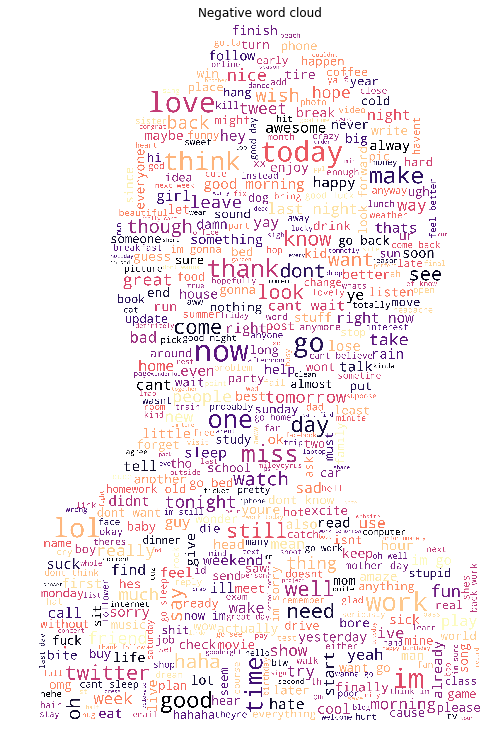

In [123]:
wordcloud_plot(classified_df,sentiment=0)

**Wordcloup of tweets with positive sentiment**

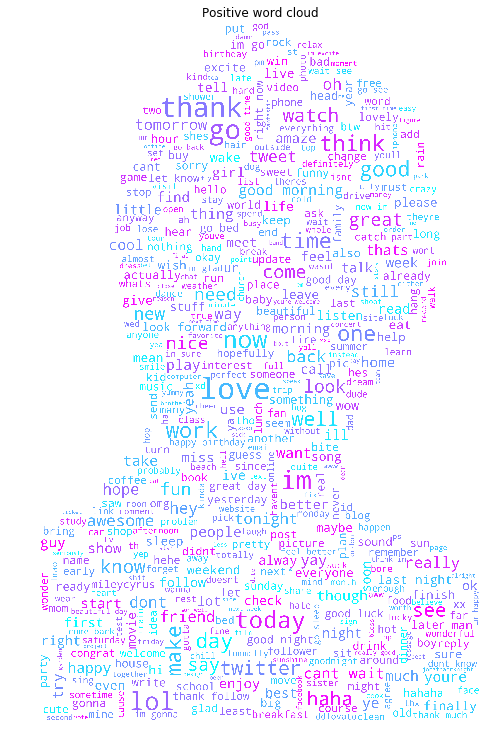

In [124]:
wordcloud_plot(classified_df,sentiment=4)

### 3 Model Preparation &  Model Implementation
In the following section the cleaned tweets list from the previous section are used as the features, and the class label list is used as target. Both the feature and target list are split into training and test set at a ratio of 70%/30%.

The textual features are encoded with various encoding method, and the encoded features are trained with LogisticRegression model and 2-Layer fully connected neural nets to get the optimized accuracy.

Here is a summary of models used below:
- **TF-IDF vectorized feature + Logistic Regression**
    - Accuracy score on train set is: 0.7084785714285714
    - Accuracy score on test set is:  0.56355
- **Pre-trained GloVe model encoding + Logistic Regression**
    - Accuracy score on train set is: 0.7457285714285714
    - Accuracy score on test set is:  0.7482166666666666
- **Pre-trained GloVe model encoding + 2-Layer DNN**
    - Accuracy score on train set is: 0.7776
    - Accuracy score on test set is:  0.77008
     
For the logistic regression model, GridSearch is performed to tune the regularization param (C) and loss function (L1/L2).
3-Fold cross-validation is performed by Gridsearch to select the optimized Hyperparameter, then the test_accurary is obtained with the test set.

In [30]:
from gensim.models.doc2vec import TaggedDocument,Doc2Vec
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer


C:\Users\sx449_000\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning:

detected Windows; aliasing chunkize to chunkize_serial



In [31]:
# create grid search dictionary for classifiers.
lr_grid_param = {"penalty":('l1','l2'),
                 "C": (0.1,0.5,1)}

In [32]:
def get_w2v_general(tweet, size, vectors, aggregation='mean'):
    ''' 
    map word2vec vectors to each token in the tweet, then take mean
    or sum of those vectors as the reprentation of the whole sentence.
    '''
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += vectors[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggregation == 'mean':
        if count != 0:
            vec /= count
        return vec
    elif aggregation == 'sum':
        return vec

In [33]:
def model_accuracy(train,test,grid):
    '''
    Function to print accuracy score on train/test set.
    Takes train/test label as global variable
    '''
    print("Best hyperparameters generated by GridSearch: {}".format(grid.best_params_))
    print("Accuracy score on train set is: {}".format(grid.score(train,label_train)))
    print("Accuracy score on test set is: {}".format(grid.score(test,label_test)))

#### 3.1 Train/Test split
**Split train and test set at 70%/30% ratio**

In [34]:
classified_train, classified_test, label_train, label_test = train_test_split(
    classified_df['cleaned_text'], classified_df['class'], test_size=0.3, random_state=0)

In [35]:
# check train/test set size
print(classified_train.shape,classified_test.shape)

(140000,) (60000,)


#### 3.2 Baseline Model: TF-IDF Vectorizer + Logistic Regression
TF-IDF stands for term frequency-inverse document frequency.
The intuition of such encoding is that for a given corpus, the informative level of a word increase with the term frequency, but decrease with document frequency. In other words, a word is more informative if it appears frequently, however, it's informative level decreases if it appears in most of the document. 

The TF-IDF vectorizer calculates the informative scores for each document, so that to convert textual features into numerical featrues.

Here the max_features is set to 200, which means we only care about the top 200 most frequently appeared token accross the corpus.

##### 3.2.1 Model Preparation

In [36]:
vectorizer = TfidfVectorizer(max_features=200, ngram_range=(1,1))

In [37]:
classified_train_tfidf = vectorizer.fit_transform(classified_train)
classified_test_tfidf = vectorizer.fit_transform(classified_test)
unclassified_tifid =  vectorizer.fit_transform(unclassified_text)

In [38]:
# display 1st tweet in tf-idf encoding
classified_train_tfidf[:2].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.27254989, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.40700578,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

##### 3.2.2 Model Implementation

In [105]:
grid_tfidf = GridSearchCV(LogisticRegression(), param_grid=lr_grid_param)
grid_tfidf.fit(classified_train_tfidf, label_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2'), 'C': (0.1, 0.5, 1)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [106]:
model_accuracy(classified_train_tfidf,classified_test_tfidf,grid_tfidf)

Best hyperparameters generated by GridSearch: {'C': 0.5, 'penalty': 'l1'}
Accuracy score on train set is: 0.7084785714285714
Accuracy score on test set is: 0.56355


** Predict for Uncalssified Tweets **

In [306]:
baseline_prediction = grid_tfidf.predict(unclassified_tifid)
baseline_prediction = [1 if x==4 else 0 for x in baseline_prediction]
unclassified_pd['baseline']= baseline_prediction

unclassified_pd

,cleaned_unclassified,hashtag,unclassified,party,vader,baseline,dnn
0,live dream,"[cameraman, camera, cameraception, camera, cam...",﻿living the dream. #cameraman #camera #camerac...,ndp,0.2500,1,1
1,justin reason thanksgiving todays montrealthem...,"[trudeau, elxn42, quebec, montreal]",justin #trudeau's reasons for thanksgiving. to...,lpc,0.0000,1,0
2,themadape buttre allergic latex make sneeze,"[nbpoli, cdnpoli]",@themadape butt…..butt…..we’re allergic to l...,NA,-0.2960,0,0
3,massive explosions peace march kill turkey con...,"[turkey, cdnpoli]",2 massive explosions at peace march in #turkey...,NA,-0.7430,1,0
4,suggest theres bad blood between him,"[trudeau, ready4change, ndp]",#mulcair suggests there’s bad blood between hi...,lpc,-0.5423,1,0
5,se sort de la marde avec et prêt retourner avec,"[harper, trudeau, polcan]",#polqc on se sort de la marde avec #harper et ...,lpc,0.0000,0,1
6,harper give help other countries get right win...,"[cdnpoli, elxn42]",harper gave $8m to help other countries' get r...,NA,0.4019,1,1
7,tommy taylor add,[],"tommy taylor added,",NA,0.0000,1,1
8,justintrudeau thomasmulcair,[],@justintrudeau? @thomasmulcair,NA,0.0000,1,0
9,tracy retweeted tsec,[],tracy s retweeted tsec,NA,0.0000,1,1


### BONUS: Word2Vec and Simple Neural Nets

##### 3.3 Encoding with pre-trained GloVe model + Logistic Regression

Originally proposed by Penninton et al. (2014), Glove is a NLP model that convert words to vectors. Unlike famous Word2Vec model by Google, which tries to predict the centre word given context or vice versa, Glove provides a object matrix calculated from aggregated global word-pair co-occurence statistics from a corpus, and the  resulting reprentations showcase interesting linear substructures of the word vector space. [Original GloVe repo can be found here](https://nlp.stanford.edu/projects/glove/)

Here I used the pre-trained GloVe model, which has 200 demention vector representation for each word. The tweet is represented by 2 methods:
- By mean of token vectors in a tweet
- By summation of token vectors in a tweet

The encoded tweets are then feed into LogisticRegression model with GridSearch, which performs 3-Folds cross-validation to find best parameters. Then accuracy is reported on both train and test set.

In [39]:
glove_twitter = api.load("glove-twitter-200")

In [40]:
glove_twitter.most_similar('hate')

[('people', 0.792229413986206),
 ("n't", 0.7866110801696777),
 ('why', 0.7847470045089722),
 ('fuck', 0.780691385269165),
 ('dont', 0.7708503007888794),
 ('when', 0.769743800163269),
 ('swear', 0.7657259106636047),
 ('really', 0.7627530694007874),
 ('stupid', 0.7585508823394775),
 ('seriously', 0.7504259943962097)]

##### 3.3.1 Mean GloVe vector encoding + Logistic Regression

**Tweet represented by mean of token vectors**

In [41]:
train_vecs_glove_mean = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'mean') for z in classified_train]))
test_vecs_glove_mean = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'mean') for z in classified_test]))
unclassified_glove_mean = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'mean') for z in unclassified_text]))

In [114]:
grid_glove_mean = GridSearchCV(LogisticRegression(), param_grid=lr_grid_param)
grid_glove_mean.fit(train_vecs_glove_mean, label_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2'), 'C': (0.1, 0.5, 1)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [115]:
model_accuracy(train_vecs_glove_mean,test_vecs_glove_mean,grid_glove_mean)

Best hyperparameters generated by GridSearch: {'C': 0.5, 'penalty': 'l2'}
Accuracy score on train set is: 0.7450357142857142
Accuracy score on test set is: 0.7462333333333333


##### 3.3.3 Sum GloVe vector encoding + Logistic Regression

**Tweet represented by sum of token vectors**

In [42]:
train_vecs_glove_sum = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'sum') for z in classified_train]))
test_vecs_glove_sum = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'sum') for z in classified_test]))

unclassified_glove_sum = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'sum') for z in unclassified_text]))

In [112]:
grid_glove_sum = GridSearchCV(LogisticRegression(), param_grid=lr_grid_param)
grid_glove_sum.fit(train_vecs_glove_sum, label_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2'), 'C': (0.1, 0.5, 1)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [113]:
model_accuracy(train_vecs_glove_sum,test_vecs_glove_sum,grid_glove_sum)

Best hyperparameters generated by GridSearch: {'C': 0.5, 'penalty': 'l1'}
Accuracy score on train set is: 0.7457285714285714
Accuracy score on test set is: 0.7482166666666666


##### 3.4 Sum GloVe Encoding +  2-Layer Fully Connected Neural Nets
With the best performing GloVe encoded feature matrix above, a simple 2 layered fully connected Neural Net is trained and evaluated. It slightly outforms the logisticRegression model by 2%. 

In [290]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

In [153]:
binary_label_train = [1 if x==4 else x for x in label_train]
binary_label_test = [1 if x==4 else x for x in label_test]

In [294]:
def get_simple_model():
    # construct and return a very simple 2 layered fully connected neural network
    np.random.seed(40)
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(200,)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    print('compile done')
    return model

In [295]:
# Auto stop if validation accuracy stuck for 5 consecutive steps
m = get_simple_model()
filepath="w2v_01_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
m.fit(train_vecs_glove_sum, np.array(binary_label_train), validation_data=(test_vecs_glove_sum,np.array(binary_label_test)), 
                 epochs=100, batch_size=64, verbose=2,callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 256)               51456     
_________________________________________________________________
dropout_53 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 256)               65792     
_________________________________________________________________
dropout_54 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 1)                 257       
Total params: 117,505
Trainable params: 117,505
Non-trainable params: 0
_________________________________________________________________
compile done
Train on 140000 samples, validate on 60000 samples
Epoch 1/100
 - 17s - loss: 0.5148 - acc: 0.7430 - val_loss: 0.4939 - val

In [297]:
# loaded_model = load_model('weighting.05-0.7684.hdf5')
loaded_model = load_model("weighting.06-0.7701.hdf5")
loaded_model.evaluate(x=test_vecs_glove_sum, y=np.array(binary_label_test))

60000/60000 [==============================] - 6s 103us/step


[0.47637815522352855, 0.7700833333333333]

** Predict for Uncalssified Tweets **

In [307]:
dnn_prediction = loaded_model.predict_classes(unclassified_glove_sum)

unclassified_pd['dnn']= dnn_prediction

unclassified_pd

,cleaned_unclassified,hashtag,unclassified,party,vader,baseline,dnn
0,live dream,"[cameraman, camera, cameraception, camera, cam...",﻿living the dream. #cameraman #camera #camerac...,ndp,0.2500,1,1
1,justin reason thanksgiving todays montrealthem...,"[trudeau, elxn42, quebec, montreal]",justin #trudeau's reasons for thanksgiving. to...,lpc,0.0000,1,0
2,themadape buttre allergic latex make sneeze,"[nbpoli, cdnpoli]",@themadape butt…..butt…..we’re allergic to l...,NA,-0.2960,0,0
3,massive explosions peace march kill turkey con...,"[turkey, cdnpoli]",2 massive explosions at peace march in #turkey...,NA,-0.7430,1,0
4,suggest theres bad blood between him,"[trudeau, ready4change, ndp]",#mulcair suggests there’s bad blood between hi...,lpc,-0.5423,1,0
5,se sort de la marde avec et prêt retourner avec,"[harper, trudeau, polcan]",#polqc on se sort de la marde avec #harper et ...,lpc,0.0000,0,1
6,harper give help other countries get right win...,"[cdnpoli, elxn42]",harper gave $8m to help other countries' get r...,NA,0.4019,1,1
7,tommy taylor add,[],"tommy taylor added,",NA,0.0000,1,1
8,justintrudeau thomasmulcair,[],@justintrudeau? @thomasmulcair,NA,0.0000,1,0
9,tracy retweeted tsec,[],tracy s retweeted tsec,NA,0.0000,1,1


### 4. Discussion

In [343]:
def party_ratio(party_name = ['lpc','cpc','ndp','gpc','bloc']):
    # function to display statis for each party in tweet mentioning.
    party_count = np.zeros(5)
    party_pos = np.zeros(5)
    party_ratio = np.zeros(5)
    for k,v in enumerate(party_name):
        temp_count = unclassified_pd[unclassified_pd['party']== v ].shape[0]
        temp_pos = unclassified_pd[(unclassified_pd['party']== v ) & (unclassified_pd['dnn']==1)].shape[0]
        party_count[k] = (temp_count)
        party_pos[k] = (temp_pos)
        party_ratio[k] = (temp_pos/temp_count)
        print("Party: {0}\t, Mentioned Count: {1:>5},\tPositive mentioning ratio: {2}"
              .format(v,party_count[k],party_ratio[k]))
        

In [344]:
party_ratio()

Party: lpc	, Mentioned Count: 631.0,	Positive mentioning ratio: 0.4215530903328051
Party: cpc	, Mentioned Count: 373.0,	Positive mentioning ratio: 0.3726541554959786
Party: ndp	, Mentioned Count: 218.0,	Positive mentioning ratio: 0.481651376146789
Party: gpc	, Mentioned Count:   6.0,	Positive mentioning ratio: 0.6666666666666666
Party: bloc	, Mentioned Count:   3.0,	Positive mentioning ratio: 0.3333333333333333


- **Description of the modeling process**:
    - In this work, the provided classified and unclassified set are used for different purposes. Both datasets are firstly cleaned by preprocessing function to remove meaningless html tags, url and stopwords. Hashtags are extracted into an individual column.
    - Unclassified tweets are assigned party labels based on the hashtag information. Based on the result, there are 5 parties been mentioned in the hashtags, which corresponds to the 5 participated party.
    - Classified tweets are splited into train and test set, then they are encoded and modeled with several different encoding and modeling combination. Out of all combinations, pre-trained GloVe word vector model + 2 layer neural network has the best performance
    - Based on the model trained on the classified tweets, the sentiment class of unclassified tweets are predicted. Then the statistics of sentiment information of tweets on each party is analyzed.

- **Insights**
    - It's shown that the liberal party have the most mentioned counts of 631, where conservative party and NDP are less mentioned of counts 373 and 218 respectively. Meanwhile the smaller party like Green party and Bloc are seldemly mentioned.
    - From the count statistics, we can conclude that green party and Bloc party are less popular and thus less likely to win the election.
    - Among the 3 most mentioned parties, NDP has the highest positive sentiment ratio of 48%, while the conservative party only have a positive sentiment ratio of 37%. It indicates that NDP has better public support on social network, where conservative suffers more criticism.
    - Amoung all 5 parties, liberal party have the largest amount of mentioning, which is nearly twice as much as the 2nd party. It also has a relatively good positive ratio. This can be a good indicator that Liberal party is the most popular and most supported party based on the social media statistics. And thus it's more likely to win the election.
    - It's worth mentioning that the above analysis subjects to a accuracy ratio of 77% as shown in the previous section.